###  Zhao, Morrison, Parr Inversion Method:

In [1]:
import os
import psi4
import matplotlib.pyplot as plt
import numpy as np
# import numpy_html
psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v


  Memory set to   2.328 GiB by Python driver.


In [2]:
#Define Psi4 geometries. Symmetries need to be set to C1. 


Ne = psi4.geometry( 
""" 
0 1
Ne 0.0 0.0 0.0
noreorient
nocom
units bohr
symmetry c1
""" )


#n2v is driven by psi4's reference option. Make sure you set it accordingly. 
psi4.set_options({"reference" : "rhf"})

#Perform a calculation for a target density. 
#Remember that for post scf calculations, Psi4 does not update the density. 
#Thus make sure you obtain something like a dipole in order to do so. 
e, wfn_ne = psi4.properties("CCSD/aug-cc-pvtz", return_wfn=True, properties=["dipole"], molecule=Ne)

#Define inverter objects for each molcule. Simply use the wnf object from psi4 as an argument. 
ine = n2v.Inverter(wfn_ne)

#### Let us now invert the density using the [Zhao, Morrison, Parr Method](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.50.2138):

---
##### The Zhao, Morrison, Parr method works by updating self-consistently a potential generated by the difference in density. 
The driving potential at step $i$ is:

$$v_c^i(r) = \lambda \int \frac{n_i(r') - n_{0}(r')}{|r-r'|} dr'$$

where $n(r)$ is the current density iteration and $n_0(r)$ is the target density that remains fixed during the scf procedure.

The $\lambda$ parameter is a Lagrange multiplier that in the limit of $\lambda \rightarrow \infty$, allows $v_c$ to become the exact potential. In practice we won't be able to increase lambda arbitrarily but values like $25$, $50$ or $75$ are commonly used. An iterative approach also lets you perform an extrapolation technique iteratively. In order to trigger this calculation, specify more than one lambda. A reliable option to choose is to begin with $\lambda=10$ and make enough iterations to achieve desired convergence in density. 

The algorithm will need an initial potential components to guide the inversion procedure. It is common to use the "Fermi Amaldi" (FA) Potential. Let us now use all of the previous information to perform the desired inversions. 

---
##### The potential that we are looking for is driven by density difference. The potential is then added to the Fock matrix as Hartree contribution. 
##### Thus if we want to visualize the potential, we need to compute the Hartree of a combination of the obtained density and the target density according to:

$$
v_{xc}(r) = v_c(r) - (1-1/N) \cdot v_{FA}(r)
$$

In practice, the result from the scf calculation is stored in:
```
inverter.proto_density_a
inverter.proto_density_b
```
We need to provide this information to the Hartree generating function. This function uses the density stored in the initial wfn object. Thus we need to overwrite this quantity. (Be careful, this is a destructive action that will permanently remove the density within the wfn object).

##### Finally we plot as if we were trying to extract the Hartree potential according $v_c(r)$ above.

The plotting grid:

In [3]:
npoints=1001
x = np.linspace(-5,5,npoints)[:,None]
y = np.zeros_like(x)
z = y
grid = np.concatenate((x,y,z), axis=1).T

Let's do ZMP calculation. Let's first try **zmp_mixing=1**, which means that all the potentials of previous lambdas are accumulated, the larger lambda potential are meant to fix the wrong/inaccurate region of the potential of the sum of the previous potentials instead of providing an entire new potentials:
$$v_c^i(r) = v_c^{i-1}(r) + \Delta v_i = \sum_{j\leq i} \lambda_j \int \frac{n_j(r') - n_{0}(r')}{|r-r'|} dr'.$$

In [4]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=1, 
           lambda_list=np.linspace(10, 1000, 20), guide_potential_components=["fermi_amaldi"])


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.831574865990774
SCF Converged for lambda:   62. Max density difference: 3.321994866651835
SCF Converged for lambda:  114. Max density difference: 0.27614473615597035
SCF Converged for lambda:  166. Max density difference: 0.15320898349227718

ZMP halted at lambda=218.42105263157896. Density Error Stops Updating: old: 0.15320898349227718, current: 0.1848379698815279.
166.31578947368422


(-5.0, 5.0)

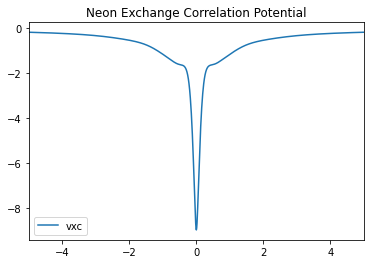

In [5]:
results = ine.on_grid_esp(Da=ine.proto_density_a, Db=ine.proto_density_b, grid=grid, )
vxc_ne = results[1]

plt.plot(x,  vxc_ne, label="vxc")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)
# plt.ylim(-10,1)

Let's modify the **zmp_mixing=0.5**: $$v_c^i(r) = \textrm{zmp_mixing} \times v_c^{i-1}(r) + \Delta v_i.$$

In [6]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0.5, 
           lambda_list=np.linspace(10, 1000, 20), guide_potential_components=["fermi_amaldi"])


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.831574863648257
SCF Converged for lambda:   62. Max density difference: 4.331348556550552
SCF Converged for lambda:  114. Max density difference: 1.478432961891258
SCF Converged for lambda:  166. Max density difference: 0.48363752646150715
SCF Converged for lambda:  218. Max density difference: 0.09675236361613315
SCF Converged for lambda:  270. Max density difference: 0.05905376797682038

ZMP halted at lambda=322.63157894736844. Density Error Stops Updating: old: 0.05905376797682038, current: 0.12011838789908325.
270.5263157894737


(-5.0, 5.0)

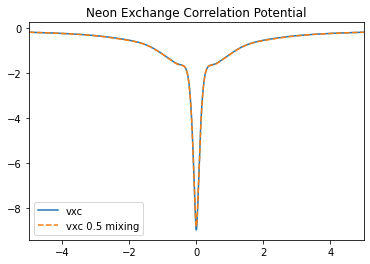

In [7]:
results = ine.on_grid_esp(Da=ine.proto_density_a, Db=ine.proto_density_b, grid=grid, )
vxc_ne1 = results[1]

plt.plot(x,  vxc_ne, label="vxc")
plt.plot(x,  vxc_ne1, label="vxc 0.5 mixing", ls="--")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)
# plt.ylim(-10,1)

Or **zmp_mixing=0**, which make only the last lambda will contribute.

In [8]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0, 
           lambda_list=np.linspace(10, 1000, 20), guide_potential_components=["fermi_amaldi"])


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.831574864224422
SCF Converged for lambda:   62. Max density difference: 5.340333569882887
SCF Converged for lambda:  114. Max density difference: 3.155368007806601
SCF Converged for lambda:  166. Max density difference: 2.2067976562328795
SCF Converged for lambda:  218. Max density difference: 1.677271082279617
SCF Converged for lambda:  270. Max density difference: 1.3399195640674861
SCF Converged for lambda:  322. Max density difference: 1.106600599951662
SCF Converged for lambda:  374. Max density difference: 0.9359062546569703
SCF Converged for lambda:  426. Max density difference: 0.8058110711615427
SCF Converged for lambda:  478. Max density difference: 0.7035194404882077
SCF Converged for lambda:  531. Max density difference: 0.6210901184134627
SCF Converged for lambda:  583. Max density difference: 0.5533348174229786
SCF Converged for lambda:  635. Max density difference: 0.49672018990531797
SCF Converged 

(-5.0, 5.0)

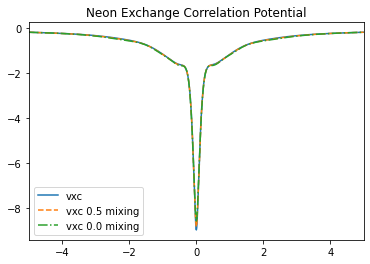

In [9]:
results = ine.on_grid_esp(Da=ine.proto_density_a, Db=ine.proto_density_b, grid=grid, )
vxc_ne2 = results[1]

plt.plot(x,  vxc_ne, label="vxc")
plt.plot(x,  vxc_ne1, label="vxc 0.5 mixing", ls="--")
plt.plot(x,  vxc_ne2, label="vxc 0.0 mixing", ls="-.")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)
# plt.ylim(-10,1)

In [10]:
ine.invert("zmp", opt_max_iter=200, opt_tol=1e-7, zmp_mixing=0.1, 
           lambda_list=np.linspace(10, 1000, 20), guide_potential_components=["fermi_amaldi"])


Running ZMP:
SCF Converged for lambda:   10. Max density difference: 15.831574864765571
SCF Converged for lambda:   62. Max density difference: 5.138568004692843
SCF Converged for lambda:  114. Max density difference: 2.7820532242741365
SCF Converged for lambda:  166. Max density difference: 1.7541256385496808
SCF Converged for lambda:  218. Max density difference: 1.1872800411849767
SCF Converged for lambda:  270. Max density difference: 0.8344484343539307
SCF Converged for lambda:  322. Max density difference: 0.5980864082625885
SCF Converged for lambda:  374. Max density difference: 0.431842378749252
SCF Converged for lambda:  426. Max density difference: 0.3108523097145053
SCF Converged for lambda:  478. Max density difference: 0.22058368674629492
SCF Converged for lambda:  531. Max density difference: 0.15198088815020583
SCF Converged for lambda:  583. Max density difference: 0.09911513437828035
SCF Converged for lambda:  635. Max density difference: 0.06136172247704508
SCF Conve

(-5.0, 5.0)

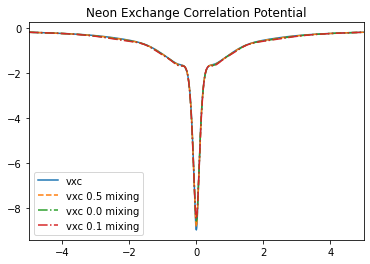

In [11]:
results = ine.on_grid_esp(Da=ine.proto_density_a, Db=ine.proto_density_b, grid=grid, )
vxc_ne3 = results[1]

plt.plot(x,  vxc_ne, label="vxc")
plt.plot(x,  vxc_ne1, label="vxc 0.5 mixing", ls="--")
plt.plot(x,  vxc_ne2, label="vxc 0.0 mixing", ls="-.")
plt.plot(x,  vxc_ne3, label="vxc 0.1 mixing", ls="-.")
plt.title("Neon Exchange Correlation Potential")

plt.legend()
plt.xlim(-5,5)
# plt.ylim(-10,1)

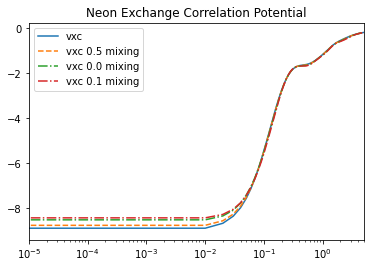

In [12]:
fig, ax = plt.subplots()
ax.plot(x,  vxc_ne, label="vxc")
ax.plot(x,  vxc_ne1, label="vxc 0.5 mixing", ls="--")
ax.plot(x,  vxc_ne2, label="vxc 0.0 mixing", ls="-.")
ax.plot(x,  vxc_ne3, label="vxc 0.1 mixing", ls="-.")
ax.set_title("Neon Exchange Correlation Potential")

ax.legend()
ax.set_xlim(1e-5,5)
ax.set_xscale("log")